In [57]:
import torch
import inspect
import math
from time import perf_counter
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import os    
import itertools 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline  

In [64]:
train_input, train_target, train_classes, test_input, test_target, test_classes  = prologue.generate_pair_sets(1000)

In [65]:
def showTensor(aTensor):
    fig = plt.figure(figsize=(5, 5), dpi=20)
    plt.axis('off')
    plt.figure()
    plt.imshow(aTensor.numpy(), cmap='Greys')
    #plt.colorbar()
    plt.show()

In [298]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        # uses BatchNorm cause otherwise the model lose the gradient with higher learning rates
        #self.norm1d = nn.BatchNorm1d(128)
        self.norm2d = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=4, stride=1))
        x = self.norm2d(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=4, stride=1))
        x = x.view(-1, 128)
        #x = self.norm1d(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model, criterion = Net(), nn.MSELoss()
eta, mini_batch_size = 1e-1, 50
nb_epochs = 10



def train_model(model, train_input,train_target, test_input, test_target, mini_batch_size = 50, nb_epochs = 10, learning_rate = 1e-1, 
                eta = 1e-1, mse = True):
    
    train_acc_loss_list = []
    test_acc__loss_list = []
    train_acc = []
    test_acc = []
    if mse == True:
        criterion = nn.MSELoss()
        F.one_hot(train_target).float()
        F.one_hot(test_target).float()
    else:
        criterion = nn.CrossEntropyLoss()
    for e in range(nb_epochs):
        acc_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            if mse == True:
                loss = criterion(output, F.one_hot(train_target).float().narrow(0, b, mini_batch_size))
            else:
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()

            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
                        

        train_acc_loss_list.append(acc_loss)
                        
        #Chech the accuracy in the train set
        pred = model(train_input).max(1)[1]
        verificar = pred == train_target
        acc = (verificar.sum().item() / train_target.size()[0]) * 100
        train_acc.append(acc)
            
        #Check the accuracy in the test set
        pred = model(test_input).max(1)[1]
        verificar = pred == test_target
        acc = (verificar.sum().item() / test_target.size()[0]) * 100
        test_acc.append(acc)
            
        #Check the loss in the test set
        output = model(test_input)
        if mse == True:
            test_loss = criterion(output, F.one_hot(test_target).float())
        else:
            test_loss = criterion(output, test_target)
        test_acc__loss_list.append(test_loss.item())
            
            
            


    return train_acc_loss_list, test_acc__loss_list, train_acc, test_acc


In [301]:
model.parameters()
for i in model.parameters():
    print(i.size())

torch.Size([16, 2, 4, 4])
torch.Size([16])
torch.Size([32, 16, 4, 4])
torch.Size([32])
torch.Size([64, 128])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([2, 32])
torch.Size([2])
torch.Size([16])
torch.Size([16])


In [299]:
_, _, train_acc, test_acc = train_model(model, train_input,train_target, 
                                        test_input, test_target, mini_batch_size = 50, 
                                        nb_epochs = 10, learning_rate = 1e-1, 
                                        eta = 1e-1, mse = False)

In [300]:
print(train_acc)
print(test_acc)

[56.39999999999999, 67.2, 71.7, 76.2, 77.7, 83.7, 82.6, 88.2, 91.4, 85.2]
[57.49999999999999, 65.9, 70.39999999999999, 72.0, 71.7, 74.8, 74.2, 77.0, 78.9, 76.2]


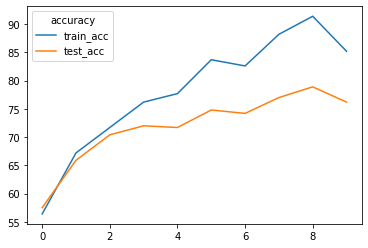

In [311]:
plt.plot(train_acc, label = "train_acc")
plt.plot(test_acc, label = "test_acc")
plt.legend(title='accuracy')
plt.show()